In [2]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon, iradon
from skimage.util import random_noise
import torch
import sys
sys.path.append('/Users/dzhansavarmail.ru/Desktop/artifact/ct_simulation-main/src/CT_simulation')
import gen_and_deg
from gen_and_deg import *


### Проблемы/идеи доработки
- gen_and_deg: в качестве примеров не просто матрицу с числами Хаунсфилда, а еще подавать синограму. Т. о. в качестве обучающего примера - тензор 512х512х2
- gen_and_deg: генерируется металлический предмет с HU = 4000. Расширить множество значений HU и сделать его не постоянным в пределах металлического предмета
- degradation: замедляется процесс из-за того, что поступает тензор(torch), он конвертируется в np массивы, они обрабатываются, потом опять превращаются в тензоры. Хочется чтобы обработка производилась над тензорами, без перевода в np. Нужно найти и настроить библиотеку, которая делает преобразования радона над тензорами


In [16]:
image = generate(num_vertices=5)

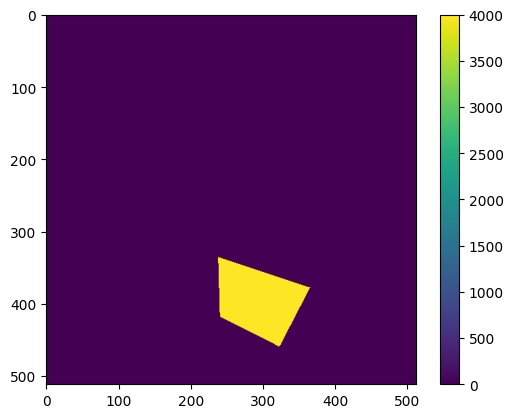

In [17]:
plt.imshow(image, cmap='viridis')
plt.colorbar()
plt.show()

In [5]:
n = 128
theta = np.linspace(0., 180., n, endpoint=False)
sigma = 1e-1
max_p = 1e5

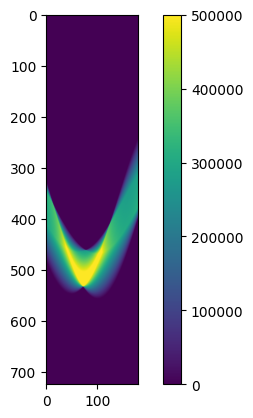

In [6]:
plt.imshow(np.clip(radon(image, circle=0), None, 500000), cmap='viridis')
plt.colorbar()
plt.show()

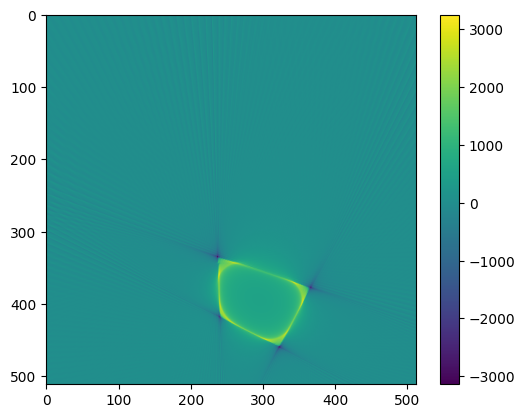

In [18]:
image_reconstructed = degradation(image, theta=theta, max_p=1e5)

plt.imshow(image_reconstructed, cmap='viridis')
plt.colorbar()
plt.show()

In [11]:
size = 512
mu = 4000   # внутри овала

center_x, center_y = size // 2, size // 2

a = 65  # полуось (по вертикали)
b = 65  # полуось (по горизонтали)

ellipse = np.zeros((size, size))

for i in range(size):
    for j in range(size):
        # (x - x0)^2 / a^2 + (y - y0)^2 / b^2 <= 1
        if ((i - center_x) ** 2 / a ** 2) + ((j - center_y) ** 2 / b ** 2) <= 1:
            ellipse[i, j] = mu

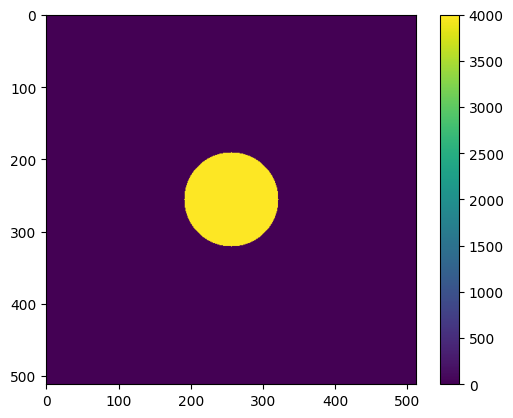

In [12]:
plt.imshow(ellipse)
plt.colorbar()
plt.show()

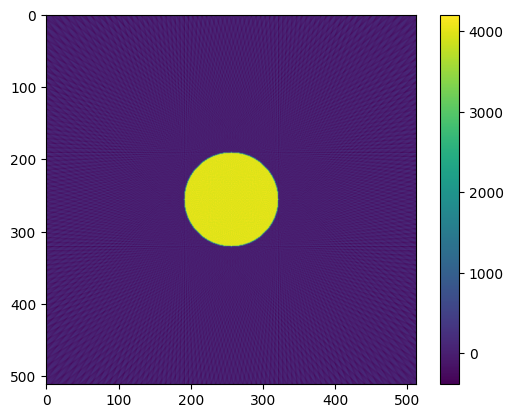

In [13]:
plt.imshow(degradation(ellipse, theta, max_p=1e6))
plt.colorbar()
plt.show()

In [18]:
def generate_v2(image_size=(512, 512), radius=(50, 90), num_vertices=8, mu=4000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image_array = torch.zeros(image_size, dtype=torch.float32, device=device)
    
    angles = torch.linspace(0, 2 * torch.pi, num_vertices, device=device)
    radii = torch.randint(radius[0], radius[1], (num_vertices,), device=device)
    x_center = torch.randint(max(radii), image_size[0] - max(radii), (1,), device=device)
    y_center = torch.randint(max(radii), image_size[1] - max(radii), (1,), device=device)
    x_vertices = radii * torch.cos(angles) + x_center
    y_vertices = radii * torch.sin(angles) + y_center
    
    y, x = torch.meshgrid(torch.arange(image_size[0], device=device),
                         torch.arange(image_size[1], device=device),
                         indexing='ij')
    px = x.reshape(-1)
    py = y.reshape(-1)
    
    cross_products = []
    for i in range(num_vertices):
        a_x = x_vertices[i]
        a_y = y_vertices[i]
        b_x = x_vertices[(i+1) % num_vertices]
        b_y = y_vertices[(i+1) % num_vertices]
        cp = (b_x - a_x) * (py - a_y) - (b_y - a_y) * (px - a_x)
        cross_products.append(cp)
    cross_products = torch.stack(cross_products, dim=0)
    min_cp = cross_products.min(dim=0).values
    mask_flat = min_cp >= 0
    mask = mask_flat.view(image_size[0], image_size[1])
    
    image_array[mask] = mu
    return image_array

In [14]:
def generate2_v2(image_size=(512, 512), radius=(50, 90), num_vertices=8, mu=4000):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    num_arrays = torch.randint(1, 4, (1,), device=device).item()
    final_array = torch.zeros(image_size, dtype=torch.float32, device=device)
    used_pixels = torch.zeros(image_size, dtype=torch.bool, device=device)

    for _ in range(num_arrays):
        while True:
            vertices = torch.randint(5, num_vertices+1, (1,), device=device).item()
            shift = torch.randint(0, (radius[1] - radius[0]) // 3, (1,), device=device).item()
            rad = (radius[0] + shift, radius[1] - shift)
            new_array = generate_v2(image_size=image_size, radius=rad, num_vertices=vertices, mu=mu)
            overlap = torch.logical_and(new_array > 0, used_pixels)
            if not torch.any(overlap):
                break
        used_pixels = torch.logical_or(used_pixels, new_array > 0)
        final_array += new_array

    return final_array

In [16]:
def degradation_v2(image, theta=torch.linspace(0., 180., 128), max_p=1e5, sigma=1e-1):
    device = image.device
    batch_size, height, width = 1, image.shape[0], image.shape[1]
    
    # Простая реализация преобразования Радона через проекции
    theta = theta.to(device)
    cos_theta = torch.cos(theta)
    sin_theta = torch.sin(theta)
    
    # Создаем координаты
    y, x = torch.meshgrid(torch.arange(height, device=device) - height//2,
                         torch.arange(width, device=device) - width//2,
                         indexing='ij')
    x, y = x.float(), y.float()
    
    # Вычисляем проекции
    sinogram = torch.zeros((len(theta), width), device=device)
    for i, (ct, st) in enumerate(zip(cos_theta, sin_theta)):
        # Поворот координат
        rot_x = x * ct + y * st
        # Проекция (суммирование вдоль оси)
        proj = torch.histogram(rot_x.view(-1), bins=width, range=(-width/2, width/2),
                             weight=image.view(-1))[0]
        sinogram[i] = proj
    
    # Добавляем шум
    noise = torch.randn_like(sinogram) * sigma
    sinogram_noisy = torch.clamp(sinogram + noise, max=max_p)
    
    # Обратное преобразование (упрощённое)
    image_recon = torch.zeros_like(image)
    for i, (ct, st) in enumerate(zip(cos_theta, sin_theta)):
        # Распределение проекции обратно по изображению
        proj = sinogram_noisy[i]
        grid_x = (x * ct - y * st + width/2).long()
        valid = (grid_x >= 0) & (grid_x < width)
        image_recon += torch.where(valid, proj[grid_x.clamp(0, width-1)], 0.0)
    
    return image_recon / len(theta)

# def degradation_v2(image, theta=None, max_p=1e5, sigma=1e-1):
#     device = image.device
#     if theta is None:
#         theta = torch.linspace(0., 180., 128, device=device)
    
#     sinogram = radon_transform(image, theta)
#     noise = torch.randn_like(sinogram) * sigma
#     sinogram_noisy = sinogram + noise
#     sinogram_real = torch.clamp(sinogram_noisy, max=max_p)
#     image_real = iradon_transform(sinogram_real, theta)
    
#     return image_real

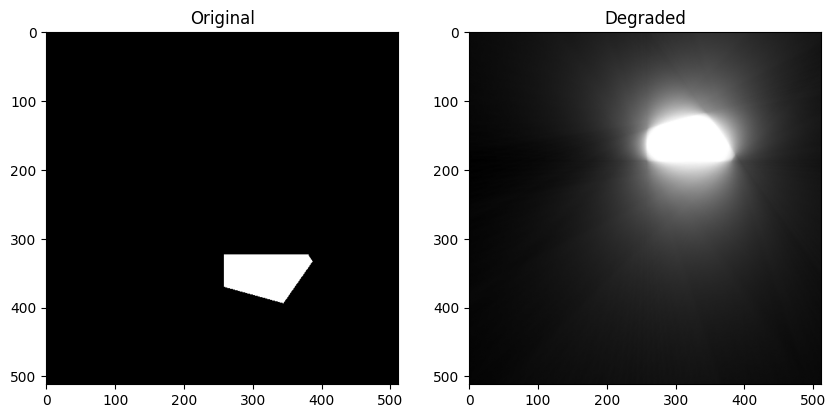

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
# Генерируем изображение
img = generate2_v2().to(device)

degraded_img = degradation_v2(img, max_p=1e5)

# Визуализация
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.imshow(img.cpu().numpy(), cmap='gray')
plt.title('Original')
plt.subplot(122)
plt.imshow(degraded_img.cpu().numpy(), cmap='gray')
plt.title('Degraded')
plt.show()

In [29]:
torch.max(degraded_img)

tensor(100000.)